# Exploratory Data Analysis

### Exploration: EDA for 2013 flight data.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
        .builder \
        .master("local[*]") \
        .config("spark.executor.memory", "16g") \
        .config("spark.driver.memory", "16g") \
        .config("spark.memory.offHeap.enabled",True) \
        .config("spark.memory.offHeap.size","16g") \
        .appName("Airline") \
        .getOrCreate()


        # .config("spark.sql.shuffle.partitions",60) \

In [5]:
flights_df = spark.read.option("header",True).csv('Data_Dump/data/flights/')
flights_df.createOrReplaceTempView("Flights")
flights_df=flights_df.select([when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c),0).otherwise(col(c)).alias(c) for c in flights_df.columns])
#checking if the file has any NaN values
flights_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flights_df.columns]).show()


+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|      0| 

### Exploration: Which Airports have the Most Delays?

In [3]:
groupedDelay = spark.sql("SELECT ORIGIN, count(*) conFlight ,avg(DEP_DELAY) delay \
                                FROM Flights \
                                GROUP BY ORIGIN")

df_origin = groupedDelay.toPandas()
df_origin=df_origin.sort_values('delay',ascending=0).head(10)

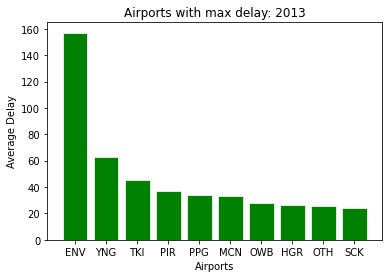

In [31]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

x = df_origin['ORIGIN']
y = df_origin['delay']
fig, ax = plt.subplots()
ax.set_title("Airports with max delay: 2013")
plt.xlabel('Airports')
plt.ylabel('Average Delay')
ax.bar(x, y, width, color='g', edgecolor="white", linewidth=0.7)
plt.show()

### How much delay does each carrier have in a month

In [21]:
Origin_Airport="EWR"
df_ORG = sqlContext.sql("SELECT * from Flights WHERE ORIGIN='"+ Origin_Airport+"'")
df_ORG.createOrReplaceTempView("df_ORG")
#UniqueCarrier=sqlContext.sql("SELECT DISTINCT(OP_CARRIER) from Flights")

In [23]:
print("total flights from this EWR from 1st JAN 2013 to 31st DEC 2013 : " + str(df_ORG.count()))

total flights from this EWR from 1st JAN 2013 to 31st DEC 2013 : 1182327


Text(0.5, 1.0, 'How much delay does EWR(Newark Liberty) has in each month?')

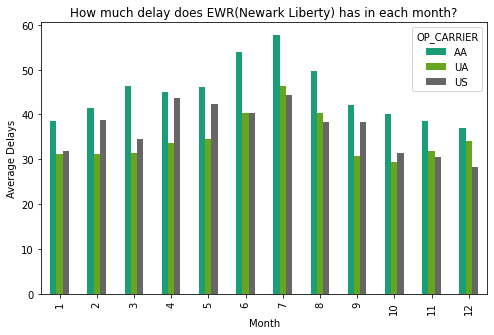

In [31]:
from pylab import rcParams
import matplotlib.pyplot as plt

grp_carr = sqlContext.sql("SELECT  OP_CARRIER,MONTH(FL_DATE) as Month, avg(DEP_DELAY) avgDelay from df_ORG \
                            WHERE DEP_DELAY>0\
                            GROUP BY OP_CARRIER,MONTH(FL_DATE)")
s = grp_carr.toPandas()
ps = s.pivot(index='Month', columns='OP_CARRIER', values='avgDelay')[['AA','UA','US']]
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Dark2');
plt.xlabel('Month')
plt.ylabel('Average Delays')
plt.title('How much delay does EWR(Newark Liberty) has in each month?')

### What are primary reasons for delay?

In [6]:
cause_delay = sqlContext.sql("SELECT sum(WEATHER_DELAY) Weather,sum(NAS_DELAY) NAS,sum(SECURITY_DELAY) Security,sum(LATE_AIRCRAFT_DELAY) lateAircraft,sum(CARRIER_DELAY) Carrier\
                              FROM Flights ")


In [7]:
df_cause_delay = cause_delay.toPandas()
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,30271933.0,164069226.0,894499.0,265217564.0,202989368.0
